## 5) 양방향 LSTM을 이용한 개체명 인식(Named Entity Recognition using Bi-LSTM)

이번 챕터에서는 개체명 인식 데이터에 대한 전처리를 진행하고, 양방향 LSTM을 이용하여 개체명 인식기를 만든다. 그리고 F1-Score를 사용하여 모델을 평가한다.



### 1.실습을 진행하기 전에

* CRF layer는 현재 텐서플로우 1.14.0 버전과 케라스 2.2.4에서 가장 원활하게 동작한다. 텐서플로우와 케라스 버전을 높이면 CRF layer가 동작하지 않거나, mask_zero = True가 되지 않는 등의 문제가 발생한다. 그러므로 우선 버전을 맞춰주자. 로컬 환경의 버전은 건드리지 않기 위해 구글 Colab에서의 실습을 권장한다.


In [ ]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0

CRF를 사용하기 위해 keras_contrib를 설치해야 한다. 아래의 명령을 수행하여 설치한다.


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

### 2.개체명 인식 데이터에 대한 이해와 전처리

이번에는 양방향 LSTM과 CRF를 함께 사용하여 앞서 사용한 데이터 외에 다른 데이터를 사용하여 개체명 인식을 수행해보도록 하겠다. 데이터는 아래의 링크에서 다운로드 가능하다.

링크 : https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus



In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd drive/My Drive/데이터

/content/drive/My Drive/데이터


In [ ]:
ls

 _about.txt            fra-eng.zip                        ner_dataset.csv
'강우예측AI 데이터'/   fra.txt                            ratings.txt
 best_model.h5         IWSLT16.TED.tst2011.en-cs.en.xml   train.txt
 eng_w2v               model.png                          wikiextractor/


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
data = pd.read_csv('ner_dataset.csv', encoding = 'latin1')

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


이번에 사용할 데이터는 앞서 사용한 데이터랑 양식이 조금 다르다. 첫번째 열은 다음과 같은 패턴을 가지고 있다. Sentence: 1 있고, Null 값이 이어지다가 Sentence: 3이 나오고 다시 Null 값이 이어지다가를 반복한다. 그런데 사실 이는 하나의 문장을 여러 행으로 나눠놓은 것이다. 숫자값을 t라고 하자. 첫번째 Sentence: t부터 Null 값이 나오다가 Sentence: t+1이 나오기 전까지의 모든 데이터는 원래 하나의 행. 즉, 하나의 샘플이어야 한다. t번째 문장을 각 단어마다 각 하나의 행으로 나눠놓은 데이터이기 때문이다. 이는 뒤에서 Pandas의 fillna를 통해 하나로 묶는 작업을 해준다.


In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


현재 data의 행의 개수는 1,048,575개이다. 하지만 뒤에서 기존에 문장 1개였던 행들을 1개의 행으로 병합하는 작업을 해야 하기 때문에 최종 샘플의 개수는 이보다 줄어들게 된다. 우선, 데이터를 좀 더 살펴보자.


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


Sentence #열에 Null 값들이 존재하고 있으므로, isnull().values.any()를 수행하였을 때 True가 나온다.


In [ ]:
print('어떤 열에 Null 값이 있는지 출력')
print('===============================')
data.isnull().sum()

어떤 열에 Null 값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

isnull().sum()을 수행하면 각 열마다의 Null 값의 개수를 보여준다. 다른 열은 0개인데, 오직 Sentence #열에서만 1,000,616개가 나온 것을 볼 수 있다. 전체 데이터에서 중복을 허용하지 않고, 유일한 값의 개수를 셀 수 있게 해주는 nunique()를 사용해보자.


In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))


sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


이 데이터에는 47,959개의 문장이 있으며 문장들은 35,178개의 단어를 가지고 17개 종류의 개체명 태깅을 가진다. 17개의 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인해보도록 하겠다.


In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name = 'count'))


Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


BIO 표현 방법에서 아무런 태깅도 의미하지 않은 O가 887,908개로 가장 많은 개수를 차지함을 볼 수 있다. 이제 데이터를 원하는 형태로 가공해보겠다. 우선 Null 값을 제거한다.


In [ ]:
data = data.fillna(method = 'ffill')

Pandas의 (method = 'ffill')는 Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채우는 작업을 수행한다. 이렇게 하면 t번째 문장에 속하면서 Null 값을 가진 샘플들은 전부 첫번째 열에 Sentence: t의 값이 들어간다. 이번에는 뒤의 5개의 샘플을 출력해서 정상적으로 수행되었는지 확인해보자.



In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


뒤의 5개 샘플의 첫번째 열이 Sentence: 47959로 채워졌다. 이는 47,959번째 문장임을 의미하며, Null 값을 가진 행들의 바로 앞 행의 Sentence # 열의 값이 Sentence: 47959이었음을 의미한다. 전체 데이터에 Null 값이 존재하는지 확인해보자.


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))


데이터에 Null 값이 있는지 유무 : False


없는 것으로 나온다. 모든 단어를 소문자화하여 단어의 개수를 줄여보겠다.


In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))


Word 열의 중복을 제거한 값의 개수 : 31817


정상적으로 소문자화가 되었는지 앞의 샘플 5개만 출력해보겠다.


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


이제 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행한다.


In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp['Word'].values.tolist(),
                                            temp['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]
print('전체 샘플 개수 : {}'.format(len(tagged_sentences)))

전체 샘플 개수 : 47959


1,000,616개의 행의 개수가 각 문장 당 하나의 샘플로 묶이면서 47,959개의 샘플로 변환된 것을 확인할 수 있다. 정상적으로 수행이 되었는지 첫번째 샘플에 대해서 출력을 해보자.


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


전처리가 수행된 첫번째 샘플이 출력된 것을 볼 수 있다. 이러한 샘플이 총 47,959개가 있다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 한다. 즉, [('thousands', 'O'), ('of', 'O')]와 같은 문장 샘플이 있다면 thousands와 of는 같이 저장하고, O와 O를 같이 저장할 필요가 있다.

이런 경우 파이썬 함수 중에서 zip() 함수가 유용한 역할을 한다. zip() 함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 한다. (2챕터의 데이터의 분리 챕터 참고)



In [ ]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.

    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에, 개체명 태깅 정보들은 tag_info에 저장.

    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에, 태깅 정보는 ner_tags에 저장하였다. 임의로 첫번째 문장 샘플을 출력해보겠다.


In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 개체명에 대해서만 ner_tags[0]에 저장된 것을 볼 수 있다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 ner_tags는 예측 대상인 y에 해당된다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 99번째 샘플에 대해서도 확인해보겠다.


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


단어에 대해서만 sentences[98]에, 또한 개체명에 대해서만 ner_tags[98]에 저장된 것을 확인할 수 있다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있다. 사실 47,959개의 문장 샘플의 길이는 전부 제각각이다. 전체 데이터의 길이 분포를 확인해보자.



샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


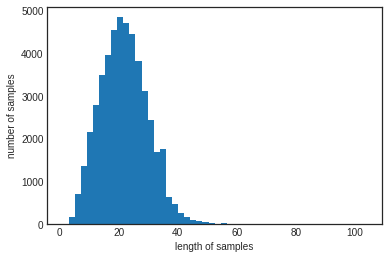

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences)) / len(sentences)))

plt.style.use(['seaborn-white'])
plt.hist([len(s) for s in sentences], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지는 것을 보여준다. 길이가 가장 긴 샘플의 길이는 104이다. 이제 케라스 토크나이저를 통해서 정수 인코딩을 진행한다. 이번에는 문장 데이터에 있는 모든 단어를 사용하겠다.


In [ ]:
src_tokenizer = Tokenizer(oov_token = 'OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower = False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용한다.


In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


앞서 src_tokenizer를 만들 때 Tokenizer의 인자로 oov_token = 'OOV'를 선택했다. 이렇게 하면 인덱스 1에 단어 'OOV'가 할당된다.


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


이제 정수 인코딩을 수행한다.


In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

이제 문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_train, 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_train에 저장되었다. 정수 인코딩이 되었는지 확인을 위해 임의로 첫번째 샘플을 출력해보겠다.


In [ ]:
print(X_train[0])
print(y_train[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word를 만든다. 그와 동시에 뒤에서 사용할 index_to_ner도 만든다. 이때, 인덱스 0은 'PAD'란 단어를 할당해두겠다. index_to_ner은 개수가 적으니 출력까지 해보자.


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word

ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word

index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


index_to_word를 만들었으니 시험삼아 첫번째 샘플에 대해서 다시 디코딩(정수에서 다시 텍스트 데이터로 변환) 작업을 해보겠다.


In [ ]:
decoded = []

for index in X_train[0]: # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


이제 X 데이터와 y 데이터가 구성되었다. 이제 패딩 작업을 진행해보자. 앞서 확인하였듯이 대부분의 데이터의 길이는 40~60에 분포되어져 있다. 그러므로 가장 긴 샘플의 길이인 104가 아니라 70정도로 max_len을 정해보겠다.


In [ ]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
y_train = pad_sequences(y_train, padding = 'post', maxlen = max_len)

모든 샘플의 길이가 70이 되었다. 이제 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리한다.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = 0.2,
                                                    random_state = 777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행한다.


In [ ]:
y_train = to_categorical(y_train, num_classes = tag_size)
y_test  = to_categorical(y_test , num_classes = tag_size)


이제 각 데이터 크기를 확인해보겠다.


In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))

print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


### 3.F1-Score

시퀀스 레이블링 모델을 평가할 때는 한 가지 주의할 점이 있다. 이런 모델의 경우에는 보통 큰 의미를 갖지 않는 레이블 정보가 존재한다. 예를 들어 개체명 인식에서는 그 어떤 개체도 아니라는 의미의 'O'라는 태깅이 존재한다. 그런데 이런 정보는 보통 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도 평가 방법을 사용하는 것이 적절하지 않을 수 있다.

예를 들어 모델이 단 1개의 개체도 맞추지 못하고 전부 'O'로 예상했을 경우를 보자. 우선 실제값은 바로 위에서 출력했던 값을 실제값으로 재사용하겠다. 아래 코드에서는 true라는 변수에 저장하였다. 그리고 개체를 하나도 맞추지 못했다는 가정하에 전부 'O'로만 채워진 예측값 predicted를 생성한다.


In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값

predicted=['O'] * len(true) #실제값의 길이만큼 전부 'O'로 채워진 리스트 생성. 예측값으로 사용.
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


실제로는 PER, MISC, PER, MISC, PER이라는 총 5개의 개체가 존재함에도 불구하고 예측값인 predicted는 단 1개의 개체도 맞추지 못한 상황을 시뮬레이션하는 것이다. 이제 이에 대한 정확도를 계산해보자.


In [ ]:
hit = 0 # 정답 개수
for t, p in zip(true, predicted):
    if t == p:
        hit += 1 # 정답인 경우에는 +1

accuracy = hit / len(true) # 정답 개수를 총 개수로 나눈다.
print('정확도 : {:.1%}'.format(accuracy))

정확도 : 74.4%


실제값에서도 대부분의 값이 'O'이기 때문에 그 어떤 개체도 찾지 못하였음에도 74%의 정확도를 얻는다. 이는 정확도가 뻥튀기되어 모델의 성능을 오해할 수 있다는 문제가 있다. 그래서 여기서는 위와 같은 상황에서 더 적절한 평가 방법을 도입하고자 한다. 윈도우의 명령 프롬프트나 UNIX의 터미널에서 아래의 명령을 수행하여 파이썬 패키지 seqeval를 설치한다.


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=21368b7d067eb407a007c3efc828f3b08bb1f89d7ef5c7f186e6d235113b7c51
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


앞서 머신러닝 훑어보기 챕터에서 정밀도(precision)과 재현율(recall)을 배운 바 있다. 개체명 인식 모델의 성능 측정을 위해 정밀도와 재현률 개념을 사용해보겠다. 이를 개체명 인식 문제에 맞도록 해석해보면 다음과 같다.

<br>

$정밀도 = \frac{TP}{TP + FP} = \text{특정 개체라고 예측한 경우 중에서 실제 특정 개체로 판명되어 예측이 일치한 비율}$

$재현률 = \frac{TP}{TP + FN} = \text{전체 특정 개체 중에서 실제 특정 개체라고 정답을 맞춘 비율}$

정밀도와 재현률로부터 조화 평균(harmonic mean)을 구한 것을 F1-Score라고 한다.

$f1\ score = 2 × \frac{\text{정밀도 × 재현률}}{\text{정밀도 + 재현률}}$

predicted의 성능을 평가하기 위해서 정밀도, 재현률, f1-score를 계산해보도록 하겠다.


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


이러한 측정 방법을 사용하면 PER과 MISC 두 특정 개체 중에서 실제 predicted가 맞춘 것은 단 1개도 없는 것을 확인할 수 있다. 이번에는 어느 정도는 정답을 맞추었다고 가정하고 예측값인 predicted를 수정하여 정밀도, 재현률, f1-score를 확인해보자.


In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



특정 개체로 예측한 경우에 대해서는 모두 제대로 예측을 하였으므로 정밀도는 1이 나온다. 하지만 재현률에서는 MISC는 실제로는 4개임에도 2개만을 맞추었으므로 0.5, PER은 실제로는 3개임에도 2개만을 맞추었으므로 0.67이 나온 것을 볼 수 있다.


### 4.F1-Score를 측정하는 콜백 클래스



In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

Using TensorFlow backend.


모델을 학습하는 과정에서 검증 데이터에 대한 F1-Score를 출력하기 위해 다음과 같은 클래스를 구현한다. 이렇게 클래스를 구현해두면 모델을 검증 데이터를 통해 검증하는 과정에서 F1-score를 지속적으로 확인할 수 있다. 그리고 F1-Score가 가장 높아질 때마다 모델을 저장한다.


In [ ]:
class F1score(Callback):

    def __init__(self, value = 0.0, use_char = True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner을 사용하여 태깅 정보로 변경하는 함수.
    
        result = []
        for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
            tag = []
            for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
                pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0, 0]이면 1의 인덱스인 2를 리턴한다.
                tag.append(index_to_ner[pred_index].replace('PAD', 'O')) # 'PAD'는 'O'로 변경

            result.append(tag)
        return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs = {}):

        # char Embedding을 사용하는 경우
        if self.use_char:
            X_test = self.validation_data[0]
            X_char_test = self.validation_data[1]
            y_test = self.validation_data[2]
            y_predicted = self.model.predict([X_test, X_char_test])
        else:
            X_test = self.validation_data[0]
            y_test = self.validation_data[1]
            y_predicted = self.model.predict([X_test])

        pred_tags = self.sequences_to_tags(y_predicted)
        test_tags = self.sequences_to_tags(y_test)

        score = f1_score(pred_tags, test_tags)
        print(' - f1: {:04.2f}'.format(score * 100))
        print(classification_report(test_tags, pred_tags))

        # F1-Score가 지금까지 중 가장 높은 경우
        if score > self.value:
            print('f1_score improved from %f to %f, saving model to best_model.h5' % (self.value, score))
            self.model.save('best_model.h5')
            self.value = score
        else:
            print('f1_score did not improve from %f' % (self.value))

### 5.BiLSTM을 이용한 개체명 인식기



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_len, mask_zero = True))
model.add(Bidirectional(LSTM(256, return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size, activation = 'softmax')))

model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           4072832   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 512)           788480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 18)            9234      
Total params: 4,870,546
Trainable params: 4,870,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(0.001), metrics = ['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train,
                 batch_size = 128, epochs = 15,
                 validation_split = 0.1,
                 callbacks = [F1score(use_char = False)])


Train on 34530 samples, validate on 3837 samples
Epoch 1/15
34530/34530 [==============================] - 83s 2ms/step - loss: 0.5544 - acc: 0.8778 - val_loss: 0.2353 - val_acc: 0.9352
 - f1: 63.04


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve       0.00      0.00      0.00        30
         geo       0.68      0.79      0.73      3087
         gpe       0.90      0.91      0.91      1146
         nat       0.00      0.00      0.00        16
         org       0.35      0.30      0.32      1691
         per       0.44      0.53      0.48      1310
         tim       0.68      0.69      0.68      1672

   micro avg       0.61      0.65      0.63      8989
   macro avg       0.38      0.40      0.39      8989
weighted avg       0.60      0.65      0.62      8989

f1_score improved from 0.000000 to 0.630423, saving model to best_model.h5
Epoch 2/15
34530/34530 [==============================] - 79s 2ms/step - loss: 0.1639 - acc: 0.9526 - val_loss: 0.1498 - val_acc: 0.9554
 - f1: 74.19
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve   

In [ ]:
bilstm_model = load_model('best_model.h5')

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = bilstm_model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis = -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print('{:15}|{:5}|{}'.format('단어', '실제값', '예측값'))
print(35 * '-')

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD 값은 제외함.
        print('{:17}: {:7} {}'.format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
        

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [ ]:
f1score = F1score()

y_predicted = bilstm_model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.67      0.04      0.07        52
         geo       0.75      0.86      0.80      7620
         gpe       0.95      0.93      0.94      3145
         nat       0.00      0.00      0.00        37
         org       0.62      0.48      0.54      4033
         per       0.72      0.72      0.72      3545
         tim       0.83      0.82      0.83      4067

   micro avg       0.77      0.77      0.77     22562
   macro avg       0.57      0.48      0.49     22562
weighted avg       0.76      0.77      0.76     22562



In [ ]:
print('F1-score : {:.1%}'.format(f1_score(test_tags, pred_tags)))

F1-score : 76.9%
